In [ ]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


7ª Reunião (Remota)
- resolver pendências das últimas reuniões
- funcionar o RCE (em 3 etapas)
- interface beta para todos os parâmetros do AE

8ª Reunião (Remota)
- RCE - retirar a memória. o Conjunto elite é sempre novo a cada vez a RCE é chamada.- Incluir array com valores dos limites inferiores e superiores das variáveis de decisão nos dados de entrada do algoritmo.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão.
- Finalizar relatório (inclusão da tabela, explicação RCE e autoavaliação).

9ª Reunião (Remota)
- Verificar pendências
- verificar setup e ver se toolbox e create estão de acordo. Usar notebook feito pelo Rainer de referência.
- Utilizar estruturas do DEAP (individual) para as variáveis de decisão.

## Classe Setup e DataExploration

In [ ]:
import numpy as np
import math
from deap import base, creator, tools
import random
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
import json
import pandas as pd


class Setup:
    def __init__(self, params):
        self.params = params
        self.CXPB = params["CROSSOVER"]
        self.MUTPB = params["MUTACAO"]
        self.NGEN = params["NUM_GENERATIONS"]
        self.POP_SIZE = params["POP_SIZE"]
        self.IND_SIZE = params["IND_SIZE"]
        self.CROSSOVER, self.MUTACAO, self.NUM_GENES, self.POPULATION_SIZE = (
            0.9,
            0.05,
            100,
            100,
        )
        self.type = params["type"].lower()
        if self.type == "maximize":
            print("Método escolhido: Maximizar")
            creator.create("Fitness", base.Fitness, weights=(1.0,))
        else:
            print("Método escolhido: Minimizar")
            creator.create("Fitness", base.Fitness, weights=(-1.0,))

        creator.create("Individual", list, fitness=creator.Fitness)
        self.SIZE_INDIVIDUAL = 10
        self.evaluations = 0
        self.num_repopulation = int(self.NUM_GENES * 0.20)
        self.dataset = {}
        self.beta_constants = {}

        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)

        self.toolbox = base.Toolbox()
        self.toolbox.register("attribute", random.random)
        self.toolbox.register(
            "individual",
            tools.initRepeat,
            creator.Individual,
            self.toolbox.attribute,
            n=self.SIZE_INDIVIDUAL,
        )
        self.toolbox.register(
            "population", tools.initRepeat, list, self.toolbox.individual
        )

        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        self.toolbox.register("evaluate", self.evaluate_fitness)

    def evaluate_fitness(self, individual):

        if self.type == "minimaze":
            result = minimize(self.rastrigin, x0=np.zeros(self.IND_SIZE), method="BFGS")
            fitness_value = result.fun
        elif self.type == "maximize":
            result = minimize(
                self.rastrigin, x0=np.zeros(self.IND_SIZE), method="Nelder-Mead"
            )
            fitness_value = -1 * result.fun
        return fitness_value

    def gerarDataset(self, excel):
        df = pd.read_excel(excel)
        print(df.columns)
        self.dataset = {
            "CXPB": self.CROSSOVER,
            "TAXA_MUTACAO": self.MUTACAO,
            "NUM_GEN": self.NUM_GENES,
            "POP_SIZE": self.POPULATION_SIZE,
            "IND_SIZE": self.SIZE_INDIVIDUAL,
            "evaluations": self.evaluations,
            "NUM_REPOPULATION": self.num_repopulation,
        }

    def rastrigin(self, individual):
        self.evaluations += 1
        rastrigin = 10 * self.SIZE_INDIVIDUAL
        for i in range(self.SIZE_INDIVIDUAL):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rastrigin_decisionVariables(self, individual, decision_variables):
        self.evaluations += 1
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin

    def rosenbrock(self, x):
        return np.sum(100 * (x[1:] - x[:-1] ** 2) ** 2 + (1 - x[:-1]) ** 2)

    def globalSolutions(self):
        n_dimensions = 2

        try:
            rastrigin_result = minimize(
                self.rastrigin, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rastrigin_minimum = rastrigin_result.fun
            rastrigin_solution = rastrigin_result.x

            rosenbrock_result = minimize(
                self.rosenbrock, x0=np.zeros(n_dimensions), method="BFGS"
            )
            rosenbrock_minimum = rosenbrock_result.fun
            rosenbrock_solution = rosenbrock_result.x

        except Exception as e:
            print("Erro ao tentar encontrar o ótimo global das funções: ", e)

        print("\n\nÓtimo global da função Rastrigin: ", rastrigin_minimum)
        print("Solução: ", rastrigin_solution)
        print()
        print("Ótimo global da função Rosenbrock: ", rosenbrock_minimum)
        print("Solução: ", rosenbrock_solution)


## Algoritimo Evolutivo RCE

In [ ]:

class AlgoritimoEvolutivoRCE:
    def __init__(self, setup):
        self.setup = setup
        self.stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        self.stats.register("avg", np.mean)
        self.stats.register("std", np.std)
        self.stats.register("min", np.min)
        self.stats.register("max", np.max)

        self.logbook = tools.Logbook()
        self.hof = tools.HallOfFame(1)
        self.pop = self.setup.toolbox.population(n=self.setup.POP_SIZE)
        self.pop_RCE = []
        self.hof.update(self.pop)

        self.best_solutions_array = []
        self.best_individual_array = []
        self.fitness_array = []
        self.CONJUNTO_ELITE_ARRAY = []
        self.allIndividualValuesArray = []
        self.data = {}
        self.repopulation_counter = 0
        self.allFitnessValues = {}
        self.validateCounter = 0
        self.CONJUNTO_ELITE_RCE = set()

    #!RCE
    def apply_RCE(self, population):
        """Aplicar o critério de repopulação com elitismo (RCE)"""

        # Adicionar o melhor indivíduo da população atual ao conjunto elite
        # self.addBestIndividualOfGenerationToRCE()

        # All individuos gerados
        all_df = pd.DataFrame(self.allIndividualValuesArray)
        print("TAMANHO ATUAL DE TODOS INDIVIDUOS", all_df.shape[0])
        self.add_best_individual_to_RCE(all_df)

        # Critério 1
        best_ind_array = self.select_best_elitismo_RCE(all_df)

        # Critério 2
        self.conjuntoElite(best_ind_array)

        # Critério 3
        self.generateConjuntoEliteWithRandomPopulation()

        # Repopulate
        elite_with_fitness = [
            ind for ind in self.CONJUNTO_ELITE_ARRAY if ind.fitness.values
        ]
        new_population = self.repopulate_RCE(self.pop, elite_with_fitness)
        return new_population

    def elitismoSimples(self):
        # print("\nSimple Elitism being applied! in Generation:", current_generation + 1)
        self.hof.update(self.pop)
        best_individual = None

        # Encontrar o melhor indivíduo do hall da fama com um fitness válido e maior que 0.0
        for ind in self.hof:
            if ind.fitness.valid and ind.fitness.values[0] != 0.0:
                # print("Melhor indivíduo encontrado!", ind.fitness.values[0])
                best_individual = ind
                break

        # Verificar se o melhor indivíduo foi encontrado e se seu fitness não é (0, 0)
        if best_individual is not None and best_individual.fitness.values != (0, 0):
            # Atualizar o primeiro indivíduo da população com o melhor indivíduo encontrado
            self.pop[0] = self.setup.toolbox.clone(best_individual)

    def add_best_individual_to_RCE(self, df):
        # Encontrar o índice da linha com o menor fitness
        index_min_fitness = df["Fitness"].idxmin()

        # Obter os valores da linha com o menor fitness
        best_individual_values = df.loc[[index_min_fitness]]
        best_individual_values["RCE"] == "SIM"
        print(
            "\n\nMelhor da geração:",
            str(best_individual_values["Generations"])[5:].strip(),
        )
        display(best_individual_values)
        print(best_individual_values["Fitness"].values[0])
        # Adicionar os valores ao array self.pop_RCE
        if not (
            best_individual_values["Fitness"].values[0] == 0.0
            or len(best_individual_values["Fitness"].values) == 0,
        ):

            self.pop_RCE.append(best_individual_values.to_dict("records")[0])
            print("Melhor da geração Adicionado no RCE!")

    def conjuntoElite(self, best_ind_1, delta=1):
        """Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."""
        isDiferente = False
        self.cout(
            "CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes."
        )

        # Loop sobre os indivíduos da geração atual
        for i in range(len(best_ind_1)):
            current_individual = best_ind_1[i]
            # print("\n---> Indivíduo atual:", current_individual["index"])
            # Verificar se o fitness do indivíduo é zero
            if current_individual["Fitness"] == 0.0:
                continue
            # Loop sobre os outros indivíduos
            for j in range(i + 1, len(best_ind_1)):
                other_individual = best_ind_1[j]

                if current_individual["Generations"] == other_individual["Generations"]:
                    # print(                        f"---> Geração atual {current_individual['Generations'] + 1} - {current_individual['index']}x{other_individual['index']}"                    )

                    # Contador para acompanhar o número de diferenças entre as variáveis de decisão
                    diff_counter = 0

                    # Loop sobre as variáveis de decisão para comparar
                    for var_index in range(
                        len(current_individual["Variaveis de Decisão"])
                    ):
                        current_var = current_individual["Variaveis de Decisão"][
                            var_index
                        ]
                        other_var = other_individual["Variaveis de Decisão"][var_index]
                        # print("\ncalculando...")
                        # print(f"{current_var}x{other_var}")

                        # Verificar se a diferença entre as variáveis de decisão é maior do que o delta
                        if abs(current_var - other_var) > delta:
                            diff_counter += 1

                    # Se o número de diferenças for maior ou igual a 3 e o indivíduo ainda não tiver sido adicionado, adicionamos ao conjunto elite
                    if (
                        diff_counter >= 3
                        and current_individual["index"] not in self.CONJUNTO_ELITE_RCE
                    ):
                        isDiferente = True
                        self.pop_RCE.append(current_individual)
                        self.CONJUNTO_ELITE_RCE.add(
                            current_individual["index"],
                            # current_individual["Variaveis de Decisão"],
                        )
                        print(
                            f"Indivíduo Index({current_individual['index']}) diferente adicionado ao conjunto elite:  O.O  "
                        )

        # Se encontrarmos pelo menos um indivíduo com as condições especificadas, exibimos o conjunto elite
        if isDiferente:
            print("Conjunto Elite atualizado!  ultimo inserido = ", self.pop_RCE[-1])

        else:
            print("Nenhum indivíduo atende aos critérios.")

    def addBestIndividualOfGenerationToRCE(self):
        # Adicionar o melhor indivíduo da população atual ao conjunto elite
        best_current_ind = self.pop[
            self.pop.index(self.hof[0])
        ]  # Melhor indivíduo da população atual
        print("Best Current Individuo", best_current_ind.fitness.values[0], "\n")
        if best_current_ind not in self.pop_RCE:
            self.pop_RCE.append(best_current_ind)

    def select_best_elitismo_RCE(self, df, k=0.3):
        """Seleciona 30% dos melhores indivíduos de cada geração."""
        self.cout(f"CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração")

        # Fatiando o dataframe para obter os 30% melhores indivíduos de cada geração
        taxa = int(self.setup.POP_SIZE * k)
        best_individuals = []
        for i in range(1, self.setup.NGEN):

            # Ordenar os dados pela coluna "Fitness" em ordem decrescente
            df_sorted = df[df["Generations"] == i].sort_values(
                by=["Fitness"], ascending=False
            )

            top_10 = df_sorted[:taxa]

            # Converter os top 10 indivíduos para um dicionário e adicionar à lista
            top_10_dict = top_10.to_dict("records")
            best_individuals.extend(top_10_dict)

            # Retornar a lista de top 10 indivíduos de todas as gerações
            _df = pd.DataFrame(best_individuals)
            new_df_sorted = _df[_df["Generations"] == i].sort_values(
                by=["Fitness"], ascending=False
            )
            if new_df_sorted.shape[0] > 0:
                # print(                    f"Total de individuos selecionados da geração {i} ={new_df_sorted.shape[0]} ",                )
                continue
                # display(new_df_sorted[:taxa])
            else:
                # print("Nenhum individuo selecionado na geração atual")
                continue

        return best_individuals

    def repopulate_RCE(self, population, elite):
        """Realiza a repopulação substituindo parte da população pelo conjunto elite."""
        new_population = elite[:]
        remaining = len(population) - len(elite)
        new_population.extend(random.choices(population, k=remaining))

        # Avaliar o fitness dos novos indivíduos
        fitnesses = map(self.setup.toolbox.evaluate, new_population)
        for ind, fit in zip(new_population, fitnesses):
            ind.fitness.values = [fit]

        # Atualizar o hall da fama com os melhores indivíduos da nova população
        self.hof.update(new_population)

    def compareIndividual(self, delta=3):
        """Comparar as 5 variaveis de decisao de de cada inviduo e verfiicar se tem 3 diferentes."""

        # checar valores iguais

        # comparar individuos
        for i in range(0, len(self.CONJUNTO_ELITE_ARRAY)):
            for j in range(i + 1, len(self.CONJUNTO_ELITE_ARRAY)):
                result = self.pop[i] > self.pop[i]
                if result <= delta:
                    self.CONJUNTO_ELITE_ARRAY.append(self.pop[i]["variables"][i][j])

    def generateConjuntoEliteWithRandomPopulation(
        self,
    ):
        self.cout("CRITERIO 3 - CONJUNTO ELITE (20%) com o restante aleatorio(80%)")
        try:
            RCE_df = pd.DataFrame(self.pop_RCE)

            # pegando as porcentagem
            elite = len(self.pop_RCE) * 0.2
            elite = int(math.ceil(elite))
            random_population = len(self.pop) * 0.8
            print(
                f"Taxa Candidatos elite (20% de {len(self.pop_RCE)}) = {elite} | random (80% de {len(self.pop)})= {random_population}"
            )
            # print("\n\nCandidatos Conjunto Elite")
            # TODO display(RCE_df[:elite])
            print("\nResults RCE Combinando com o restante aleatorio")
            self.combinar_aleatoriamente()
        except Exception as e:
            print("Erro ao gerar novo conjunto elite", e)

    #! Main LOOP
    def run(self, RCE=False, decision_variables=None, fitness_function=None):
        # Avaliar o fitness da população inicial
        fitnesses = map(self.setup.toolbox.evaluate, self.pop)
        for ind, fit in zip(self.pop, fitnesses):
            if ind.fitness.values:
                print(f"\n\nDEBUG = {ind.fitness.values} valor positivo ")
                ind.fitness.values = [fit]

        # Verificar se as variáveis de decisão e a função de fitness foram fornecidas
        if decision_variables is None and fitness_function is None:
            # Gerar variáveis de decisão aleatórias para os indivíduos
            decision_variables = [
                random.random() for _ in range(self.setup.SIZE_INDIVIDUAL)
            ]

            # Definir a função de fitness padrão como a função Rastrigin
            fitness_function = self.setup.rastrigin_decisionVariables

        if decision_variables is None or fitness_function is None:
            if not hasattr(self, "decision_variables") or not hasattr(
                self, "fitness_function"
            ):
                raise ValueError(
                    "Variáveis de decisão e função de fitness não definidas. Use set_decision_variables_and_fitness_function primeiro."
                )
        else:
            self.decision_variables = decision_variables
            self.fitness_function = fitness_function

            # Definir a função de fitness com base na função fornecida
            def fitness_func(individual):
                return self.fitness_function(individual, self.decision_variables)

            # Registrar a função de fitness no toolbox
            self.setup.toolbox.register("evaluate", fitness_func)

        #! Loop principal através das gerações
        for current_generation in range(self.setup.NGEN):

            # Selecionar os indivíduos para reprodução
            offspring = self.setup.toolbox.select(self.pop, k=len(self.pop))
            offspring = [self.setup.toolbox.clone(ind) for ind in offspring]

            # Aplicar crossover
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.setup.CXPB:
                    self.setup.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            # Aplicar mutação
            for mutant in offspring:
                if random.random() < self.setup.MUTPB:
                    self.setup.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # todo Avaliar o fitness dos novos indivíduos
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.setup.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                # todo nao aceitar o melhor individuo ter nan u fitness 0
                ind.fitness.values = [fit]

            # Registrar estatísticas e melhores soluções
            for ind in self.pop:
                avg_fitness_per_generation = np.mean(ind.fitness.values)
                std_deviation = np.std(ind.fitness.values)

            print({"Media": avg_fitness_per_generation, "STD": std_deviation})

            #! PEgandos os dados e colocando no df
            self.data = {
                "Generations": current_generation + 1,
                "Variaveis de Decisão": self.hof[0],
                "Evaluations": self.setup.evaluations,
                "Best Fitness": self.hof[0].fitness.values,
                "Media": avg_fitness_per_generation,
                "Desvio Padrao": std_deviation,
            }

            if (
                self.data["Best Fitness"] == -0.0
                or self.data["Best Fitness"] == set()
                or self.data["Best Fitness"] == 0.0
            ):

                continue
            else:
                self.best_individual_array.append(self.data)

            self.visualizarPopAtual(
                current_generation, [avg_fitness_per_generation, std_deviation]
            )

            # Aplicar repopulação e elitismo
            self.elitismoSimples()

            if RCE and (
                self.setup.num_repopulation != 0
                and (current_generation + 1) % self.setup.num_repopulation == 0
            ):

                print(
                    f"\nRCE being applied!  - Generation = {current_generation + 1} ",
                )
                self.apply_RCE(offspring)
                # self.plot_conjuntoElite()

            else:
                self.pop[:] = offspring

            # Registrar estatísticas no logbook
            record = self.stats.compile(self.pop)
            self.logbook.record(gen=current_generation, **record)

        # Retornar população final, logbook e elite
        return self.pop, self.logbook, self.hof[0]

    def visualizarPopAtual(self, geracaoAtual, stats):
        for i in range(len(self.pop)):
            datasetIndividuals = {
                "Generations": geracaoAtual + 1,
                "index": i,
                "Variaveis de Decisão": self.pop[i],
                "Fitness": self.pop[i].fitness.values,
                "Media": stats[0],
                "Desvio Padrao": stats[1],
                "RCE": " - ",
            }
            self.allIndividualValuesArray.append(datasetIndividuals)

    def cout(self, msg):
        print(
            "\n=========================================================================================================="
        )
        print("\t", msg)
        print(
            "==========================================================================================================\n"
        )

    def combinar_aleatoriamente(self):
        try:
            elite_size = len(self.pop_RCE)
            elite_df = pd.DataFrame(self.pop_RCE)

            # Filtrar os indivíduos restantes da última geração
            all_df = pd.DataFrame(self.allIndividualValuesArray)
            remaining_individuals = all_df[
                all_df["Generations"] == all_df["Generations"].max()
            ]

            # Remover os indivíduos do conjunto elite da lista dos restantes
            remaining_individuals = remaining_individuals[
                ~remaining_individuals.index.isin(elite_df.index)
            ]

            # Selecionar aleatoriamente os indivíduos restantes da última geração para preencher
            random_individuals = remaining_individuals.sample(n=100 - elite_size)

            # Adicionar a coluna "RCE" e definir como "SIM" para os indivíduos do conjunto elite e "NÃO" para os outros
            elite_df["RCE"] = "SIM"
            random_individuals["RCE"] = "NÃO"

            # Combinar os indivíduos do conjunto elite com os indivíduos aleatórios
            new_df = pd.concat([elite_df, random_individuals])
            display(new_df)
            return new_df
        except Exception as e:
            print("Erro ao combinar aleatoriamente", e)


## Exemplo de uso

In [1]:
from src.models.AlgEvolution import AlgEvolution
from src.models.new_alg_evolution import AlgoritimoEvolutivoRCE
from src.models.Setup import Setup
from src.models.DataExploration import DataExploration
import time
from src.backend.pdf_generator import PDFGenerator
import json
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import math

# Carregar os dados
turbina = pd.read_csv('/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/assets/datasets/T1.csv')
turbina.columns = ['Data/hora', 'ActivePower(kW)', 'WindSpeed(m/s)', 'Curva_Teórica(KWh)',"Direção do Vento"]
display(turbina.head())

# Selecionar características e separar em X e y
X = turbina[['WindSpeed(m/s)']].values
y = turbina[['ActivePower(kW)']].values
data_hora = turbina[['Data/hora']].values
curva = turbina[['Curva_Teórica(KWh)']].values
vento = turbina[['Direção do Vento']].values

print(X.shape,y.shape)


# Definir a função de aptidão (fitness function) para a Turbina
def fitness_function_turbina(individual, decision_variables):
    X, y = decision_variables
    # Calcular a diferença absoluta entre a potência ativa medida e a potência teórica esperada
    diff = abs(y - individual * X)
    # Calcular a aptidão como a negação da diferença, para maximizar a semelhança
    return np.mean(diff)

def rastrigin_decisionVariables( individual, decision_variables):
        rastrigin = 10 * len(decision_variables)
        for i in range(len(decision_variables)):
            rastrigin += individual[i] * individual[i] - 10 * (
                math.cos(2 * np.pi * individual[i])
            )
        return rastrigin


def load_params(file_path):
    with open(file_path, "r") as file:
        params = json.load(file)
    return params


,Data/hora,ActivePower(kW),WindSpeed(m/s),Curva_Teórica(KWh),Direção do Vento
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


(50530, 1) (50530, 1)


Método escolhido: Minimizar
{'Media': nan, 'STD': nan}
{'Media': 39.745249667951896, 'STD': 0.0}
{'Media': 3.210065057944755, 'STD': 0.0}
{'Media': 4.130333103523922, 'STD': 0.0}
{'Media': 2.3707543338844292, 'STD': 0.0}
{'Media': 1.4611475166389134, 'STD': 0.0}
{'Media': 1.1485919650340257, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}


/home/pedrov/.local/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/lib/python3.11/site-packages/numpy/core/_m

{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}

RCE being applied!  - Generation = 20 
TAMANHO ATUAL DE TODOS INDIVIDUOS 2000


Melhor da geração: 1
Name: Generations, dtype: int64


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-


()

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.

Indivíduo Index(22) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(72) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(16) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(0) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(75) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(73) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(71) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(70) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(69) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(68) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(67) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(66) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(65) diferen

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,11,22,"[0.03967616491090942, -0.696071982604488, 0.60...","(14.119148859592736,)",0.46391,0.0,SIM
1,11,72,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.46391,0.0,SIM
2,11,16,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.46391,0.0,SIM
3,11,0,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,SIM
4,11,75,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,SIM
...,...,...,...,...,...,...,...
1931,20,31,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
1904,20,4,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
1976,20,76,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
1971,20,71,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO


{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}

RCE being applied!  - Generation = 40 
TAMANHO ATUAL DE TODOS INDIVIDUOS 4000


Melhor da geração: 1
Name: Generations, dtype: int64


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-


()

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.

Indivíduo Index(7) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(39) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(37) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(55) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(27) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(38) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(49) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(89) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(94) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(6) diferente adicionado ao conjunto elite:  O.O  
Conjunto Elite atualizado!  ultimo inserido =  {'Generations': 39, 'index': 6, 'Variaveis de Decisão': [0.03967616491090942, 0.4645172580495178, -1.04298028621442

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,11,22,"[0.03967616491090942, -0.696071982604488, 0.60...","(14.119148859592736,)",0.46391,0.0,SIM
1,11,72,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.46391,0.0,SIM
2,11,16,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.46391,0.0,SIM
3,11,0,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,SIM
4,11,75,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,SIM
...,...,...,...,...,...,...,...
3988,40,88,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
3938,40,38,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
3908,40,8,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO
3968,40,68,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.46391,0.0,NÃO


{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.4639101358926787, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}

RCE being applied!  - Generation = 60 
TAMANHO ATUAL DE TODOS INDIVIDUOS 6000


Melhor da geração: 1
Name: Generations, dtype: int64


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-


()

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.

Indivíduo Index(76) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(31) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(54) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(35) diferente adicionado ao conjunto elite:  O.O  
Conjunto Elite atualizado!  ultimo inserido =  {'Generations': 53, 'index': 35, 'Variaveis de Decisão': [-1.5836308200081983, -0.013723534749503427, 0.2827374106554378, 0.38902062194859544, 0.2729895601529938, 1.8287397839497164, 0.48670086787556655, 0.3792662507094008, 0.4806945838908076, 0.3990309978019768], 'Fitness': (21.19612089537143,), 'Media': 0.3480437336615889, 'Desvio Padrao': 0.0, 'RCE': ' - '}

	 CRITERIO 3 - CONJUNTO ELITE (20%) com o restante aleatorio(80%)

Taxa Candidatos elite (20% de 41) = 9 | random (80% de 100)= 80.0

Results RCE Combi

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,11,22,"[0.03967616491090942, -0.696071982604488, 0.60...","(14.119148859592736,)",0.463910,0.0,SIM
1,11,72,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
2,11,16,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
3,11,0,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
4,11,75,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
...,...,...,...,...,...,...,...
5984,60,84,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
5927,60,27,"[0.03967616491090942, -0.013723534749503427, -...","(0.3480437336615889,)",0.348044,0.0,NÃO
5934,60,34,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
5986,60,86,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO


{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}

RCE being applied!  - Generation = 80 
TAMANHO ATUAL DE TODOS INDIVIDUOS 8000


Melhor da geração: 1
Name: Generations, dtype: int64


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-


()

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.

Indivíduo Index(24) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(29) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(19) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(90) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(52) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(77) diferente adicionado ao conjunto elite:  O.O  
Conjunto Elite atualizado!  ultimo inserido =  {'Generations': 77, 'index': 77, 'Variaveis de Decisão': [0.03967616491090942, -0.013723534749503427, -1.0786821725221305, 0.38902062194859544, 0.5869320244700378, 0.5750568321377194, 2.308256222861005, 0.9192193250589084, 0.7579268037442883, 0.33172136170107314], 'Fitness': (0.3480437336615889,), 'Media': 0.3480437336615889, 'Desvio Padrao': 0.0, 'RCE': ' - '}

	 CRITERIO 3 - C

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,11,22,"[0.03967616491090942, -0.696071982604488, 0.60...","(14.119148859592736,)",0.463910,0.0,SIM
1,11,72,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
2,11,16,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
3,11,0,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
4,11,75,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
...,...,...,...,...,...,...,...
7989,80,89,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
7943,80,43,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
7963,80,63,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
7944,80,44,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO


{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}
{'Media': 0.3480437336615889, 'STD': 0.0}

RCE being applied!  - Generation = 100 
TAMANHO ATUAL DE TODOS INDIVIDUOS 10000


Melhor da geração: 1
Name: Generations, dtype: int64


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-


()

	 CRITÉRIO 1 RCE - 30% dos melhores fitness de cada geração


	 CRITÉRIO 2 - Comparar as variáveis de decisão de cada indivíduo e verificar se existem 3 diferentes.

Indivíduo Index(48) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(46) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(51) diferente adicionado ao conjunto elite:  O.O  
Indivíduo Index(93) diferente adicionado ao conjunto elite:  O.O  
Conjunto Elite atualizado!  ultimo inserido =  {'Generations': 97, 'index': 93, 'Variaveis de Decisão': [1.523991648216085, -0.013723534749503427, 0.2827374106554378, 0.38902062194859544, 0.5869320244700378, 0.5750568321377194, 0.4692736038164753, 0.7504161101012117, 1.9562573661837472, 0.33172136170107314], 'Fitness': (22.246488035695506,), 'Media': 0.3480437336615889, 'Desvio Padrao': 0.0, 'RCE': ' - '}

	 CRITERIO 3 - CONJUNTO ELITE (20%) com o restante aleatorio(80%)

Taxa Candidatos elite (20% de 51) = 11 | random (80% de 100)= 80.0

Results RCE Combi

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,11,22,"[0.03967616491090942, -0.696071982604488, 0.60...","(14.119148859592736,)",0.463910,0.0,SIM
1,11,72,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
2,11,16,"[0.9934940813066631, 0.027824569372300823, 0.6...","(1.1485919650340257,)",0.463910,0.0,SIM
3,11,0,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
4,11,75,"[0.03967616491090942, 0.027824569372300823, 0....","(0.4639101358926787,)",0.463910,0.0,SIM
...,...,...,...,...,...,...,...
9904,100,4,"[0.03967616491090942, -0.013723534749503427, -...","(0.3480437336615889,)",0.348044,0.0,NÃO
9969,100,69,"[0.03967616491090942, -0.013723534749503427, -...","(0.3480437336615889,)",0.348044,0.0,NÃO
9942,100,42,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,NÃO
9984,100,84,"[0.03967616491090942, -0.013723534749503427, -...","(0.3480437336615889,)",0.348044,0.0,NÃO



Evolução concluída  - 100%


Todos Individuos Gerados


,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
0,1,0,"[0.3307017574937232, 0.6364157472704026, 0.472...",(),NaN,NaN,-
1,1,1,"[0.5914460223856445, 0.6853131939423863, 0.709...",(),NaN,NaN,-
2,1,2,"[0.250227965790473, 0.44918639117281567, 0.433...",(),NaN,NaN,-
3,1,3,"[0.6299730056644754, 0.3852704120462326, 0.960...",(),NaN,NaN,-
4,1,4,"[0.8746497560693963, 0.7555417382486478, 0.382...",(),NaN,NaN,-
...,...,...,...,...,...,...,...
9995,100,95,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,-
9996,100,96,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,-
9997,100,97,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,-
9998,100,98,"[0.03967616491090942, -0.013723534749503427, 0...","(0.3480437336615889,)",0.348044,0.0,-




-->Conjunto Elite: [{'Generations': 11, 'index': 22, 'Variaveis de Decisão': [0.03967616491090942, -0.696071982604488, 0.6093671860469544, 0.7233271624157965, 0.8598869202219074, 0.9187856758800144, 0.47398340652719206, 0.9192193250589084, -0.9583725565616258, 0.33172136170107314], 'Fitness': (14.119148859592736,), 'Media': 0.4639101358926787, 'Desvio Padrao': 0.0, 'RCE': ' - '}, {'Generations': 11, 'index': 72, 'Variaveis de Decisão': [0.9934940813066631, 0.027824569372300823, 0.6093671860469544, 0.7233271624157965, 0.5869320244700378, 0.5908602255956682, 0.24219419322635516, 0.9192193250589084, 0.7579268037442883, 0.6557820216800855], 'Fitness': (1.1485919650340257,), 'Media': 0.4639101358926787, 'Desvio Padrao': 0.0, 'RCE': ' - '}, {'Generations': 11, 'index': 16, 'Variaveis de Decisão': [0.9934940813066631, 0.027824569372300823, 0.6093671860469544, 0.7233271624157965, 0.14267292608523752, 0.5908602255956682, 0.47398340652719206, 0.9192193250589084, 0.7579268037442883, 0.399030997

,Generations,index,Variaveis de Decisão,Fitness,Media,Desvio Padrao,RCE
41,64,24,"[2.498589453393065, -0.013723534749503427, 0.2...","(26.279897745649862,)",0.348044,0.0,-
50,97,93,"[1.523991648216085, -0.013723534749503427, 0.2...","(22.246488035695506,)",0.348044,0.0,-
48,94,46,"[0.03967616491090942, 1.5523750565706131, 0.28...","(22.18396438671602,)",0.348044,0.0,-
43,71,19,"[0.03967616491090942, 1.4518859620037878, 0.28...","(21.96518998293989,)",0.348044,0.0,-
42,70,29,"[0.03967616491090942, 1.567092928555537, 0.282...","(21.891011022568087,)",0.348044,0.0,-
47,92,48,"[0.03967616491090942, -1.4405556429896493, 0.2...","(21.69646323133108,)",0.348044,0.0,-
40,53,35,"[-1.5836308200081983, -0.013723534749503427, 0...","(21.19612089537143,)",0.348044,0.0,-
36,39,6,"[0.03967616491090942, 0.4645172580495178, -1.0...","(20.278984900589393,)",0.463910,0.0,-
27,23,7,"[0.03967616491090942, 0.4608726364737661, 0.28...","(20.22242755644049,)",0.463910,0.0,-
35,38,94,"[0.03967616491090942, -0.438782674535128, 0.45...","(19.772569232960233,)",0.463910,0.0,-




VISUALIZANDO OS RESULTADOS
Soluções do problema

Best solution index =  45

Best solution variables =
 [0.03967616491090942, -0.013723534749503427, 0.2827374106554378, 0.38902062194859544, 0.06607435938204953, 0.005438701226902987, 0.48670086787556655, 0.9192193250589084, 0.674753877314851, 0.33172136170107314]

Best solution fitness =  0.3480437336615889

Ótimo global da função Rastrigin =  3.0450232566356448

Solução ótima global =  [ 1.49031132e-03 -2.03733554e-03  3.02465212e-04  2.16785869e-04
  1.06187833e-03  1.71941420e-02  9.94662599e-01  9.94761494e-01
  9.95112780e-01 -1.65170762e-04]

Porcentagem de proximidade da solução em relação ao ótimo global =  88.57007962408365 %

Distância da solução em relação ao ótimo global = <built-in function abs>
100 100 100


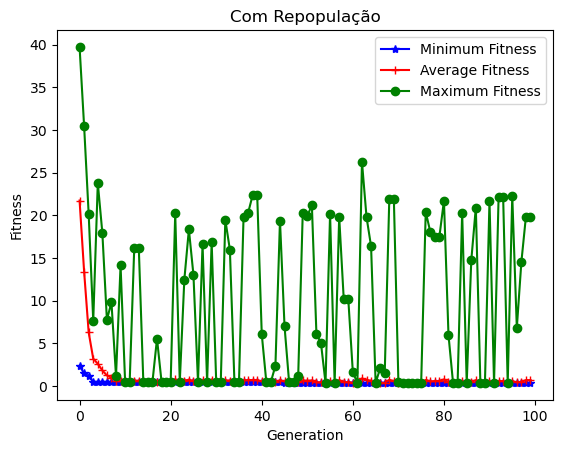

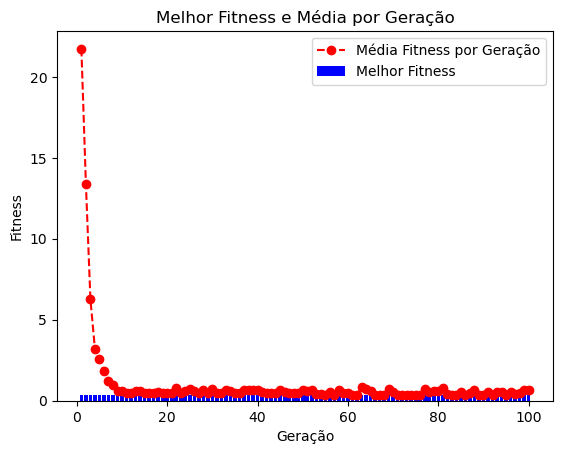

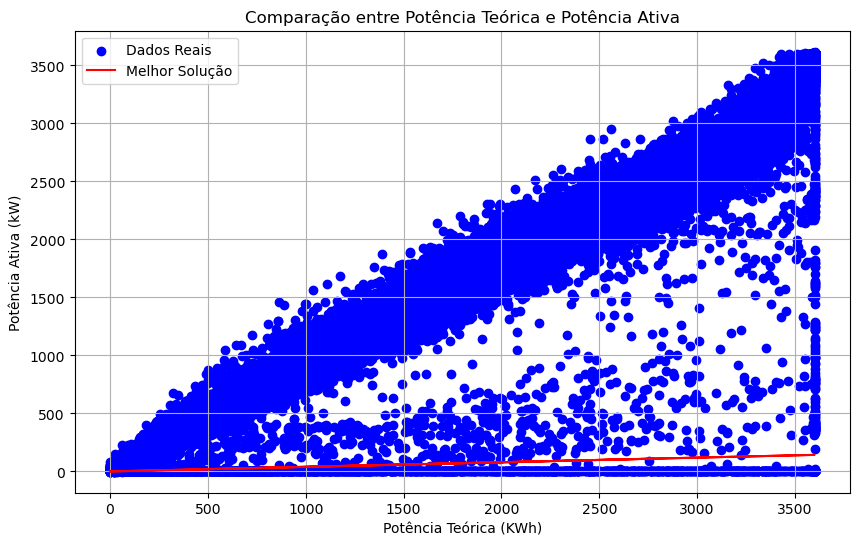

Total execution time: 10.01 seconds


In [2]:




def main():
    tempo1 = time.time()


    #Setup
    params = load_params("/home/pedrov/Documentos/GitHub/Engenharia-Eletrica-UFF/Iniciação Cientifica - Eng Eletrica UFF/evolution_rce_master/src/db/parameters.json")
    setup = Setup(params)
    alg = AlgoritimoEvolutivoRCE(setup)
    data_visual = DataExploration()

    pop_with_repopulation, logbook_with_repopulation, best_variables = alg.run(
        RCE=True,
        fitness_function=rastrigin_decisionVariables,
        decision_variables=(X, y),
        
        )
    print("\n\nEvolução concluída  - 100%")




    # Salvar resultados
    all_df = data_visual.displayDataFrameInfo(alg.allIndividualValuesArray, "\n\nTodos Individuos Gerados")
    print("\n\n-->Conjunto Elite:", alg.pop_RCE)
    best_df = pd.DataFrame(alg.pop_RCE)
    display(best_df.sort_values(by = "Fitness" ,ascending=False))


    

    
    # Visualização dos resultados
    print("\n\nVISUALIZANDO OS RESULTADOS")
    #TODO data_visual.displayDataFrameInfo(alg.best_individual_array, "Best 100 variables with repopulation")
    data_visual.visualize(
        logbook_with_repopulation, pop_with_repopulation, repopulation=True
    )
    data_visual.statistics_per_generation_df(logbook_with_repopulation)


    tempo2 = time.time()
    print(f"Total execution time: {round(tempo2-tempo1,2)} seconds")
main()  


